<a href="https://colab.research.google.com/github/TabyH/MathData24/blob/main/Halza_Math_Data_Lab_Pretrained_Folder_Alexnet_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Two possible ways to create your dataset: (1) Make one with your own with your camera/phone or (2) Build one with Image Search (Google/Bing)

The idea is to have (at least) two categories for which you will train an inference model. You will then present data from your reserved validation set to evaluate your models ability to distinguish the two categories. For example, pick any living object like ants and then collect photos with and without ants in the pictures. You will then put these pictures on your google drive and run a classification model just like with flowers 102.

The more photos you collect the better your model will be. You must have at least 50 photographs for each of your two categories. (This should not take a long time.)

Note you must put around 20% of your images into the valid folder.

Example data folders here: https://drive.google.com/drive/folders/1Je_gRF8RnhszAAbQhw2IzqM2_7byPVtL?usp=sharing

Example Ideas:

Ex1 Camera: Ant finder Close up of ground/floor with ants in photo vs Close up photo with no ants

Ex2 Camera: Palm tree with coconuts vs Palm tree with dates (Both are all over FAU)

Ex3 Web Search: Marine animal (bird) vs Marine animal covered in oil from oil spill

Ex4 Web Search: Burrowing owl adult vs Burrowing owl chick

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from skimage import io
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchsummary import summary
import torchvision
from torchvision import datasets, models, transforms

# Mount Google Drive (if using Google Colab)
from google.colab import drive
drive.mount('/content/drive')

# Set the device to GPU if available, otherwise CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define the data directory where your dataset is stored
data_dir = '/content/drive/My Drive/Data1/redlightgreenlightdataset/'

# Define the labels for your dataset classes
dataset_labels = ["green", "red"]  # Replace with your own labels if different

# Define the mean and standard deviation for image normalization
mean = [0.485, 0.456, 0.406]  # Standard mean values for ImageNet images
std = [0.229, 0.224, 0.225]   # Standard deviation values for ImageNet images

# Define data transformations for training and validation datasets
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),  # Randomly crop and resize the image to 224x224 pixels
        transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
        transforms.ToTensor(),              # Convert the image to a PyTorch tensor
        transforms.Normalize(mean, std)     # Normalize the image with mean and std
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),             # Resize the image to 256 pixels on the shorter side
        transforms.CenterCrop(224),         # Crop the center 224x224 pixels
        transforms.ToTensor(),              # Convert the image to a PyTorch tensor
        transforms.Normalize(mean, std)     # Normalize the image with mean and std
    ]),
}

def create_dataloaders(data_dir, batch_size=16):
    # Create image datasets for training and validation
    image_datasets = {
        x: datasets.ImageFolder(
            os.path.join(data_dir, x),
            data_transforms[x]
        ) for x in ['train', 'valid']
    }

    # Create dataloaders for training and validation datasets
    dataloaders = {
        x: torch.utils.data.DataLoader(
            image_datasets[x],
            batch_size=batch_size,
            shuffle=True,       # Shuffle the data for training
            num_workers=2       # Number of subprocesses to use for data loading
        ) for x in ['train', 'valid']
    }

    # Get the sizes of the datasets
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}

    # Get the class names
    class_names = image_datasets['train'].classes

    return dataloaders, dataset_sizes, class_names

def imshow(inp, title=None):
    # Move the tensor to CPU and convert to NumPy array
    inp = inp.cpu().numpy().transpose((1, 2, 0))

    # Unnormalize the image
    inp = std * inp + mean

    # Clip the values to be between 0 and 1
    inp = np.clip(inp, 0, 1)

    # Display the image
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.axis('off')  # Hide axis
    plt.show()

def train_model(model, dataloaders, dataset_sizes, num_epochs=25):

    # Move the model to the appropriate device
    model = model.to(device)

    # Define the loss function (criterion) and the optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)

    # Decay LR by a factor of 0.1 every 7 epochs
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    # Loop over the number of epochs
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluation mode

            running_corrects = 0  # Initialize the number of correct predictions

            # Iterate over the data in batches
            for inputs, labels in dataloaders[phase]:
                # Move inputs and labels to the device
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass (compute outputs and predictions)
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)            # Get model outputs
                    _, preds = torch.max(outputs, 1)   # Get predictions
                    loss = criterion(outputs, labels)  # Compute loss

                    # Backward pass + optimize (only in training phase)
                    if phase == 'train':
                        loss.backward()      # Compute gradients
                        optimizer.step()     # Update parameters

                # Update running corrects
                running_corrects += torch.sum(preds == labels.data)

            # Calculate accuracy for the epoch
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f'{phase.capitalize()} Acc: {epoch_acc:.4f}')

            # Step the learning rate scheduler after each epoch in training phase
            if phase == 'train':
                scheduler.step()

        print()  # Newline for better readability

    return model

def visualize_model(model, dataloaders, num_images=6):

    # Save the model's training mode status
    was_training = model.training

    # Set the model to evaluation mode
    model.eval()

    images_so_far = 0  # Counter for images displayed

    # Disable gradient computation
    with torch.no_grad():
        # Iterate over the validation dataset
        for inputs, labels in dataloaders['valid']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Iterate over each image in the batch
            for j in range(inputs.size()[0]):
                images_so_far += 1

                # Display the image and prediction
                imshow(
                    inputs.cpu().data[j],
                    title=f'Predicted: {dataset_labels[preds[j]]} | Actual: {dataset_labels[labels[j]]}'
                )

                # Stop after displaying the specified number of images
                if images_so_far == num_images:
                    # Restore the model's training mode status
                    model.train(mode=was_training)
                    return

    # Restore the model's training mode status
    model.train(mode=was_training)

def apply_transforms(image):

    # Check if the image is a NumPy ndarray (as returned by io.imread)
    if isinstance(image, np.ndarray):
        # Convert the NumPy ndarray to a PIL Image
        image = Image.fromarray(image)

    # Define the transformations for the test image
    test_transforms = transforms.Compose([
        transforms.Resize(256),             # Resize the image so that the shorter side is 256 pixels
        transforms.CenterCrop(224),         # Crop the center 224x224 pixels
        transforms.ToTensor(),              # Convert the image to a PyTorch tensor
        transforms.Normalize(mean, std)     # Normalize the image with mean and std
    ])

    # Apply the transformations and add a batch dimension
    image_tensor = test_transforms(image).unsqueeze(0)  # Shape: [1, 3, 224, 224]

    return image_tensor

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# Create dataloaders for training and validation datasets
dataloaders, dataset_sizes, class_names = create_dataloaders(data_dir)

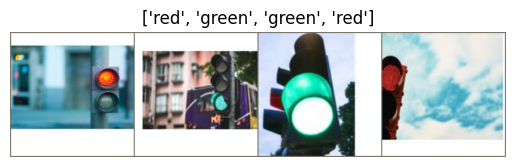

In [9]:
# Visualize some training images
inputs, classes = next(iter(dataloaders['train']))  # Get a batch of training data
out = torchvision.utils.make_grid(inputs[:4])       # Make a grid from the first 4 images
# Display the images with their labels
imshow(out, title=[dataset_labels[x] for x in classes[:4]])

In [10]:
# Initialize the pretrained AlexNet model
model = models.alexnet(pretrained=True)
# Modify the last layer to match the number of classes in our dataset
model.classifier[6] = nn.Linear(4096, len(class_names))
print(model)  # Print the model architecture

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [11]:
# Train the model for a specified number of epochs
model = train_model(model, dataloaders, dataset_sizes, num_epochs=3)

Epoch 1/3
----------
Train Acc: 0.6300
Valid Acc: 0.8600

Epoch 2/3
----------
Train Acc: 0.8700
Valid Acc: 1.0000

Epoch 3/3
----------
Train Acc: 0.9300
Valid Acc: 0.9900



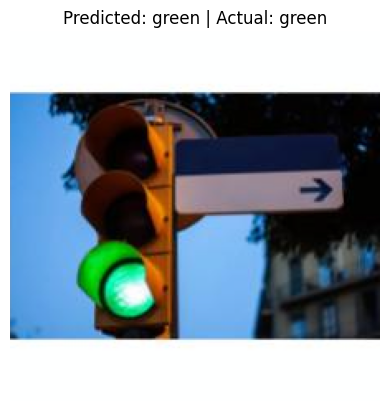

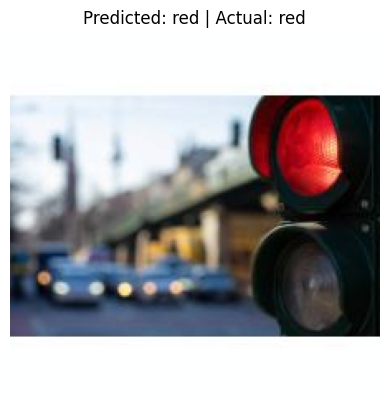

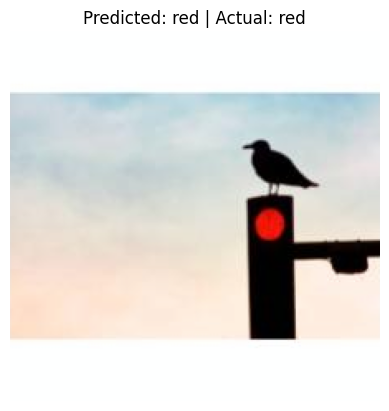

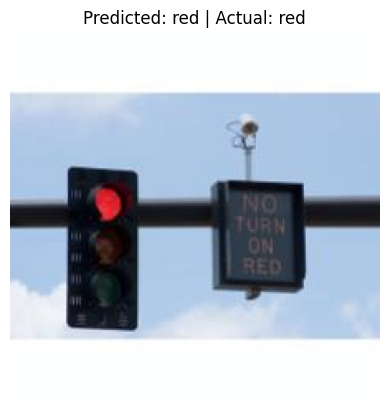

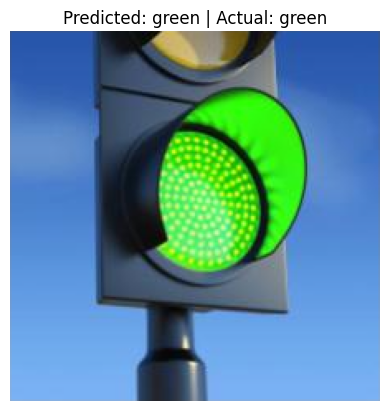

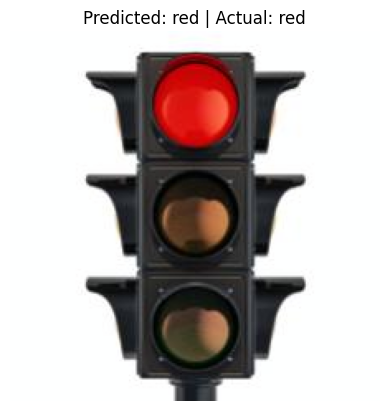

In [12]:
# Visualize the model's predictions on the validation dataset
visualize_model(model, dataloaders)

In [13]:
# Print a summary of the model architecture
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

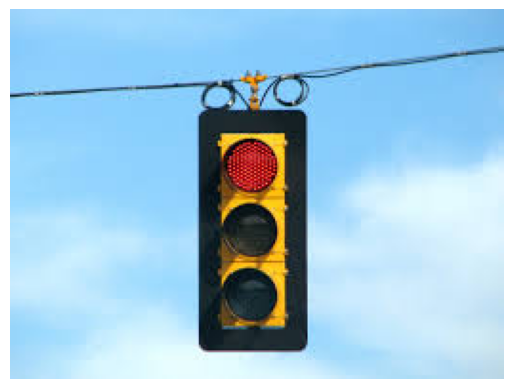

Predicted: red


In [18]:
# Test the model with an external image from a URL
image_url = 'https://raw.githubusercontent.com/TabyH/MathData24/refs/heads/main/download%20(1).jpeg'
image = io.imread(image_url)  # Read the image from the URL

# Display the test image
plt.imshow(image)
plt.axis('off')  # Hide axis
plt.show()

# Apply the necessary transformations to the test image
image_tensor = apply_transforms(image).to(device)

# Set the model to evaluation mode
model.eval()

# Make predictions on the test image
outputs = model(image_tensor)
_, preds = torch.max(outputs, 1)
# Print the predicted class
print(f'Predicted: {dataset_labels[preds[0]]}')

Confusion Matrix:
[[49  1]
 [ 0 50]]


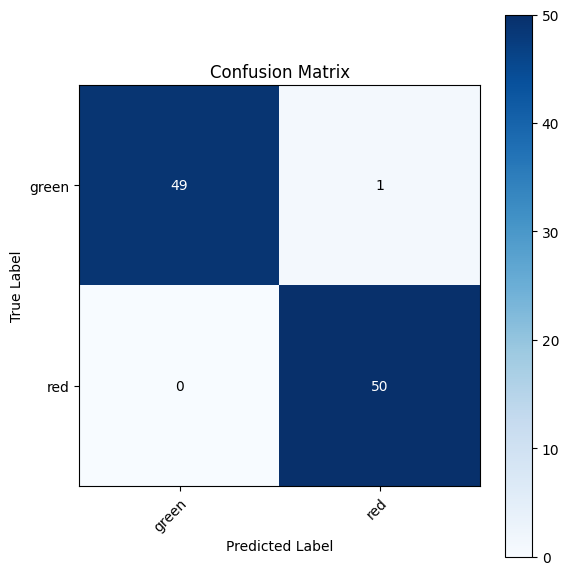

In [19]:
# Compute the confusion matrix on the validation dataset
all_preds = []
all_labels = []

# Iterate over the validation dataset
for inputs, labels in dataloaders['valid']:
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Forward pass
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)

    # Collect predictions and labels
    all_preds.append(preds.cpu().numpy())
    all_labels.append(labels.cpu().numpy())

# Concatenate all predictions and labels
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print('Confusion Matrix:')
print(cm)


import matplotlib.pyplot as plt
import numpy as np

# Assuming 'cm' is your confusion matrix and 'dataset_labels' is a list of your class names
def plot_confusion_matrix(cm, class_names):
    """
    Plots the confusion matrix using matplotlib.

    Parameters:
    - cm (array-like): Confusion matrix.
    - class_names (list): List of class names.

    Returns:
    - None
    """
    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)

    # Set tick marks and labels
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        xticklabels=class_names,
        yticklabels=class_names,
        xlabel='Predicted Label',
        ylabel='True Label',
        title='Confusion Matrix'
    )

    # Rotate the tick labels and set alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

    # Loop over data dimensions and create text annotations
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j, i, format(cm[i, j], 'd'),
                ha='center', va='center',
                color='white' if cm[i, j] > thresh else 'black'
            )

    fig.tight_layout()
    plt.show()

# Now call the function with your confusion matrix and class names
plot_confusion_matrix(cm, dataset_labels)
